# Breast Cancer Classification

- In this project suspected tumors will be classified as benign or malignant.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
)

## Loading Dataset:

In [2]:
df = pd.read_csv('Data/breast-cancer.csv')

## Data Exploration

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


- Count the total number of benign and malignant tumors in dataset, then visualize it.

In [4]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

<Axes: xlabel='diagnosis', ylabel='count'>

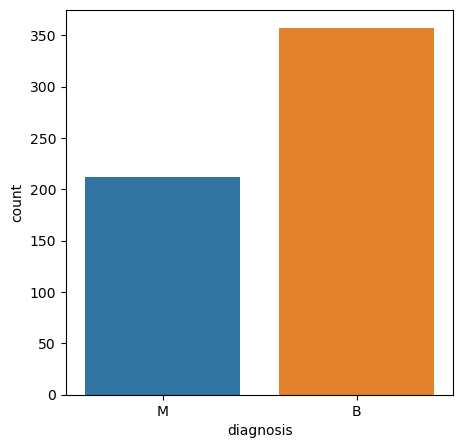

In [5]:
plt.figure(figsize=(5,5))
sns.countplot(x = 'diagnosis', data=df)

- Select four arbitrary variables and get paired plots of them.

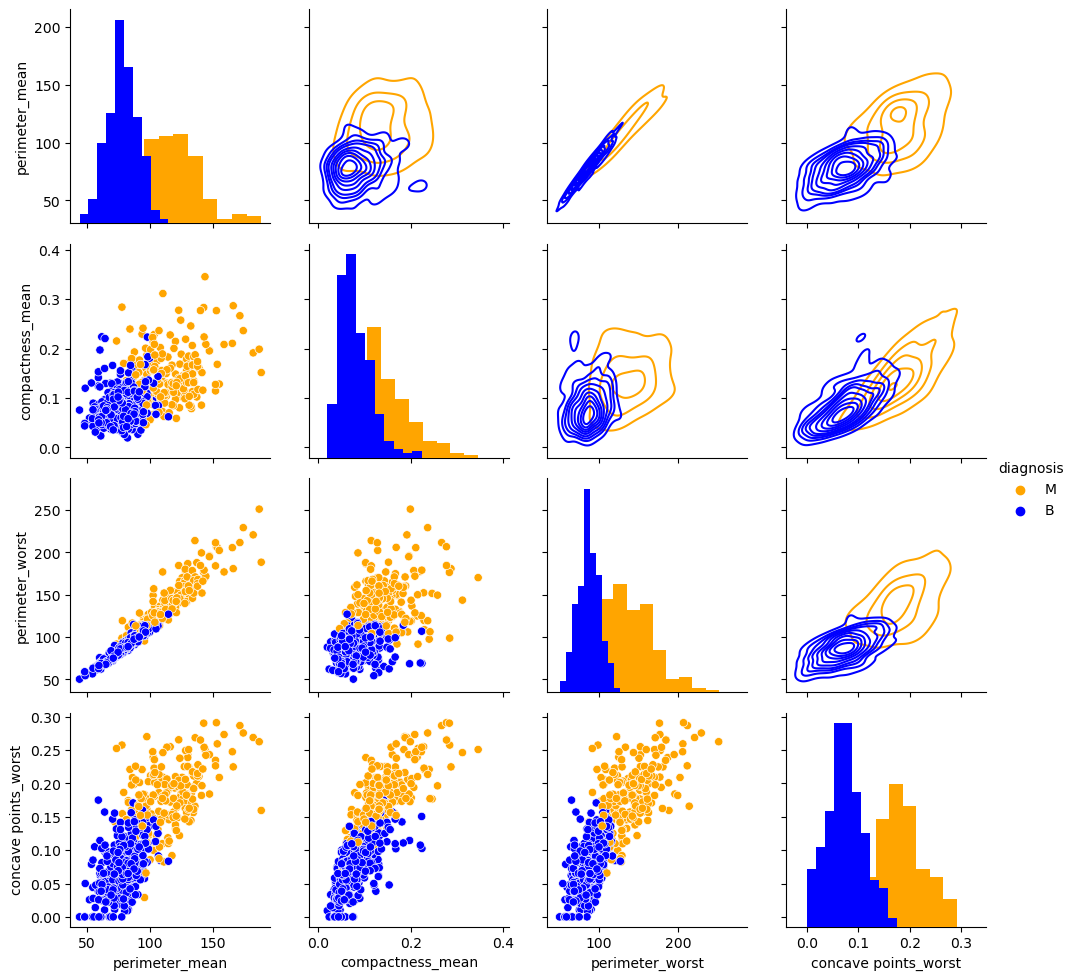

In [6]:
g = sns.PairGrid(
    df,
    vars = ['perimeter_mean', 'compactness_mean', 'perimeter_worst', 'concave points_worst'],
    hue = 'diagnosis',
    diag_sharey = False,
    palette = ['orange', 'blue']
    
)


g.map_diag(plt.hist)
g.map_upper(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.add_legend(title='diagnosis')

- Check for the missing data.

In [7]:
df.isna().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

- Look for the correlations.

/var/folders/32/rcrjgdkx5359r0ynjvd2k1x40000gn/T/ipykernel_44146/1872260564.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.loc[:, 'diagnosis':'fractal_dimension_worst'].corr(), annot=True)


<Axes: >

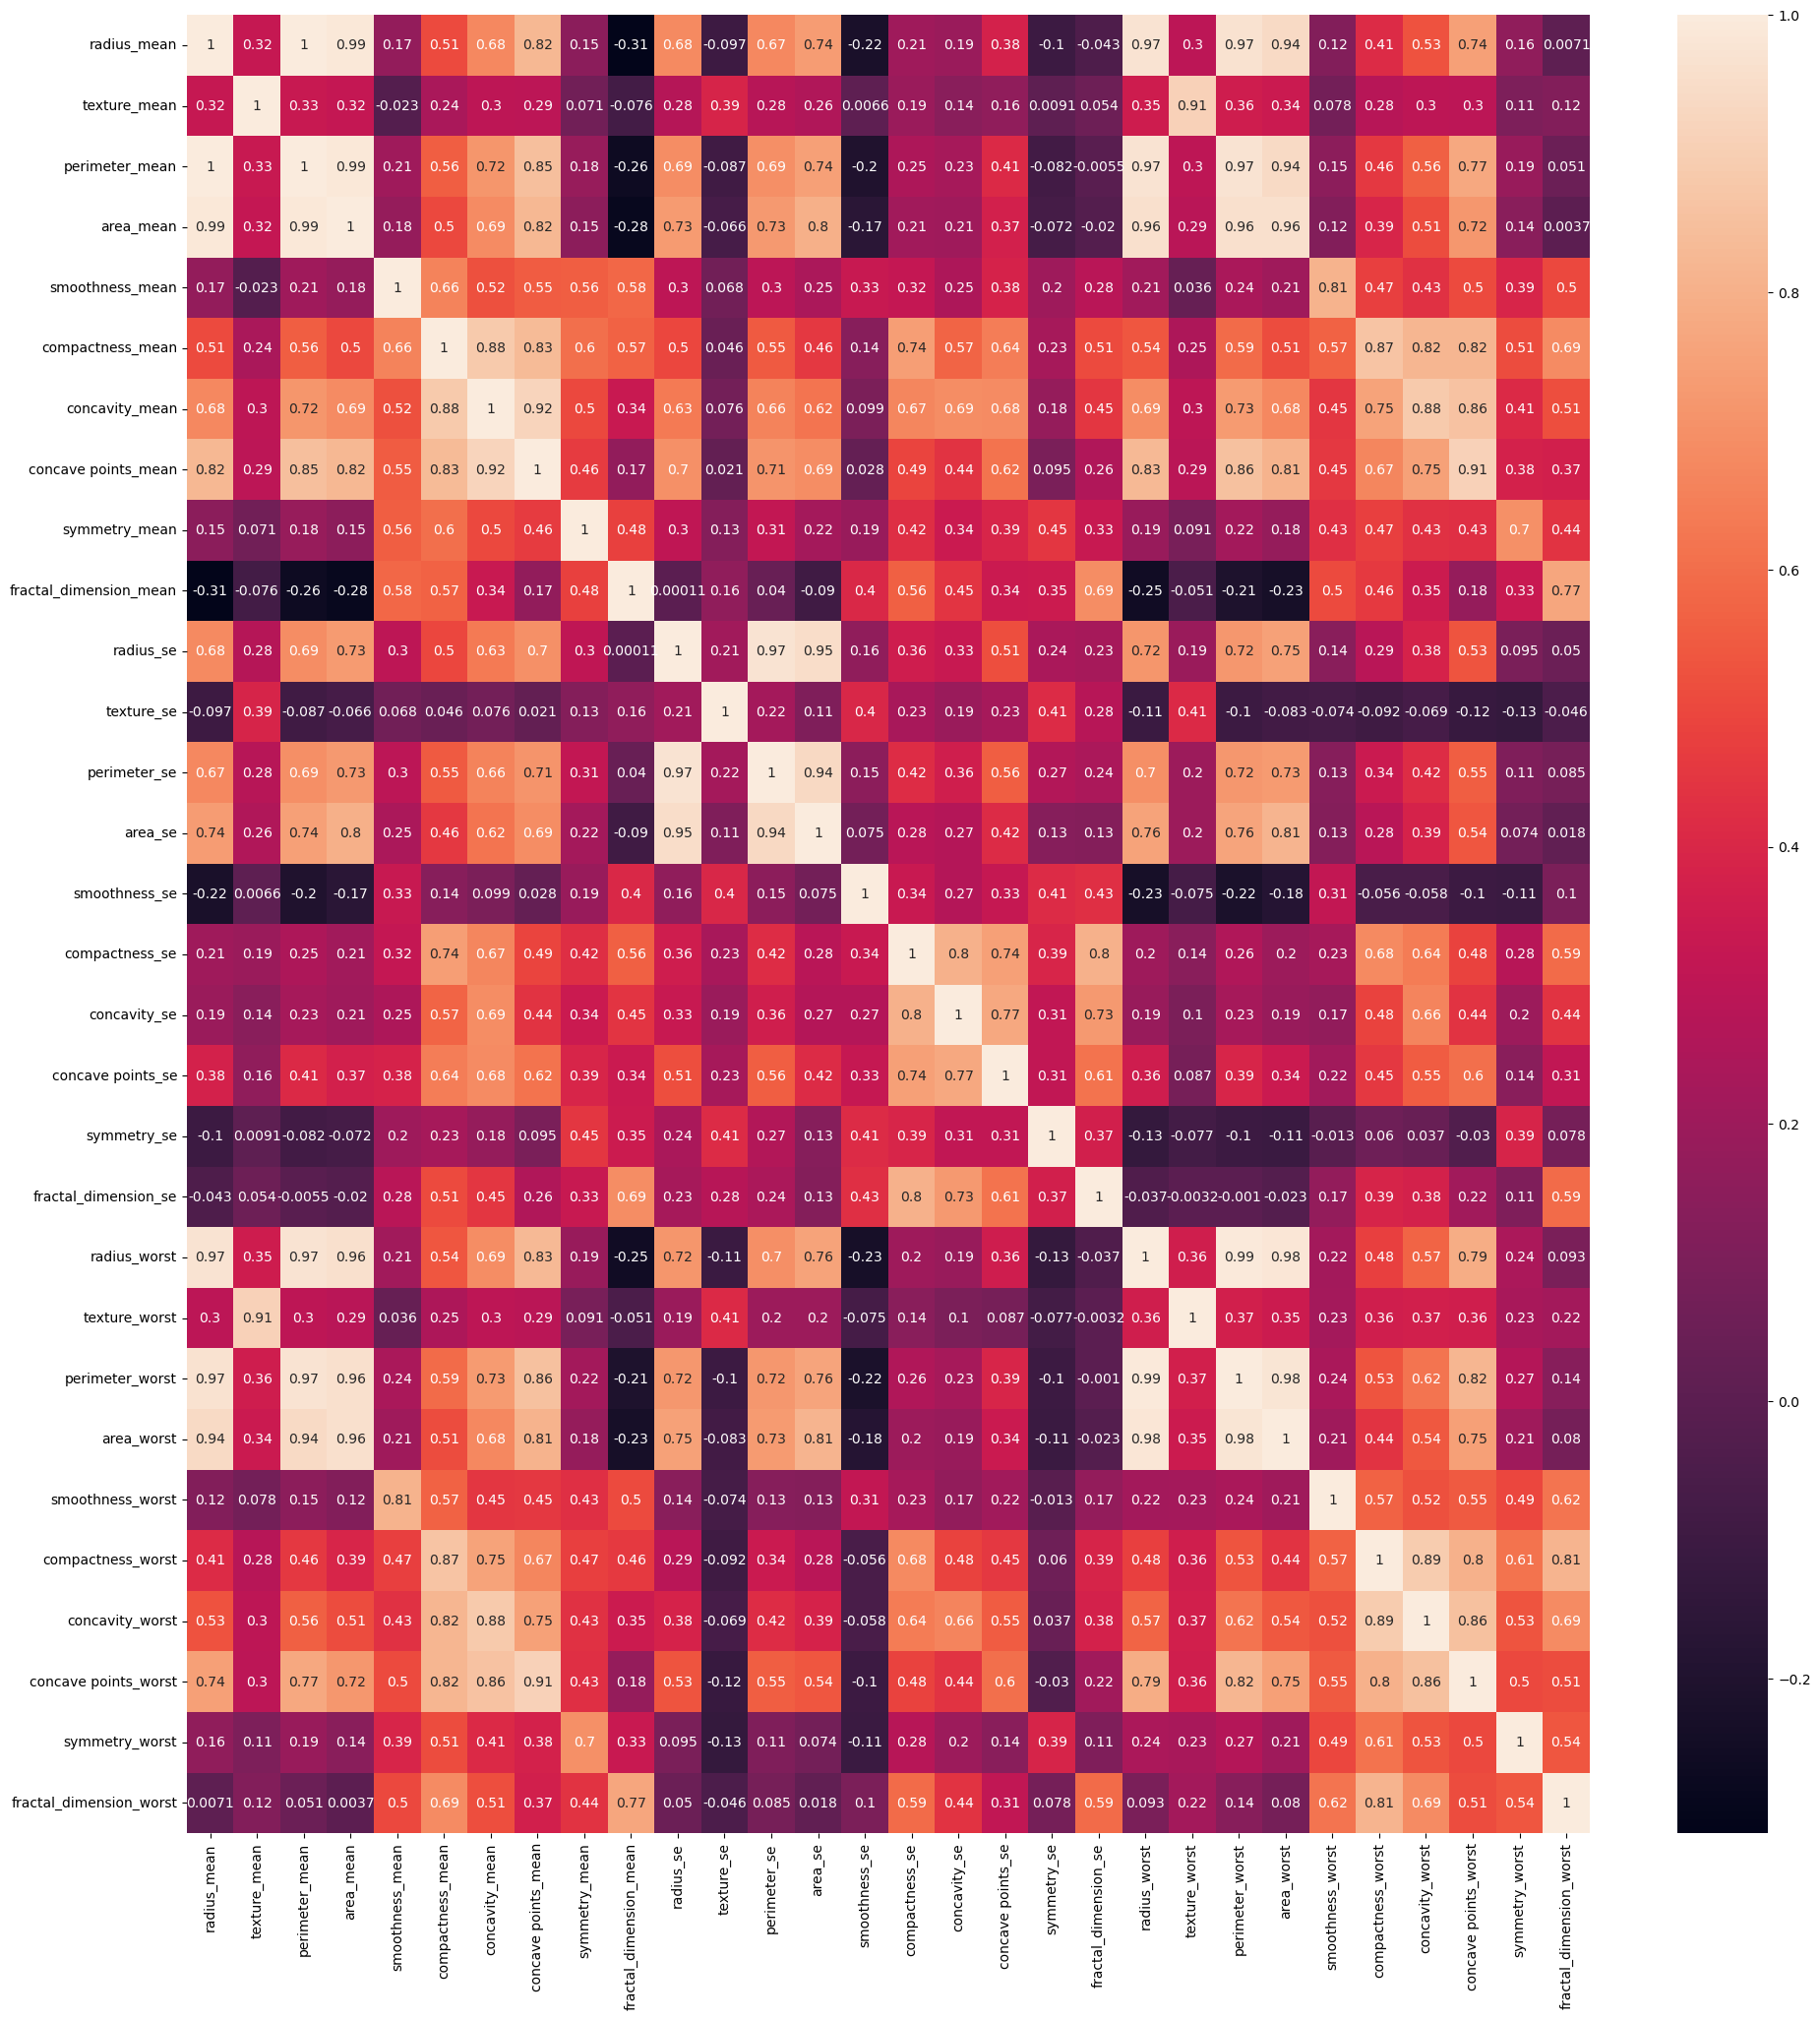

In [8]:
plt.figure(figsize=(23,24))
sns.heatmap(df.loc[:, 'diagnosis':'fractal_dimension_worst'].corr(), annot=True)

## Feature Selection

- First split the data.

In [9]:
X = df.loc[:,'radius_mean':'fractal_dimension_worst']
y = df.diagnosis

- Then standardize the data.

In [10]:
scaler = scaler = MinMaxScaler()
standardized_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(standardized_X, columns=X.columns)
scaled_X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


- Keep the most significant features in the dataset.

In [11]:
k = 5  # Number of features to keep
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(scaled_X, y) 

selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = scaled_X.columns[selected_feature_indices]

print("Selected Feature Names:")
print(selected_feature_names)


Selected Feature Names:
Index(['concavity_mean', 'concave points_mean', 'perimeter_worst',
       'area_worst', 'concave points_worst'],
      dtype='object')


## Choosing The Model

- Compare Logistic Regression and Gaussian Naive Bayes and see which model is better.

In [12]:
nb_classifier = GaussianNB()
lr_classifier = LogisticRegression()

- Perform cross validation for both models.

In [13]:
cv_nb_predictions = cross_val_predict(nb_classifier, X_new, y, cv=5, method='predict_proba')
cv_lr_predictions = cross_val_predict(lr_classifier, X_new, y, cv=5, method='predict_proba')

-  Calculate ROC AUC scores for cross-validation.

In [20]:
cv_nb_roc_auc = roc_auc_score(y, cv_nb_predictions[:, 1])
cv_lr_roc_auc = roc_auc_score(y, cv_lr_predictions[:, 1])

print("Cross-Validation ROC AUC Scores:")
print("Gaussian Naive Bayes:", cv_nb_roc_auc)
print("Logistic Regression:", cv_lr_roc_auc)

Cross-Validation ROC AUC Scores:
Gaussian Naive Bayes: 0.9812774166270282
Logistic Regression: 0.9820701865651922


- Look at the performance metrics on validation/test set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

nb_classifier.fit(X_train, y_train)
lr_classifier.fit(X_train, y_train)
nb_prob_predictions = nb_classifier.predict_proba(X_test)[:, 1]
lr_prob_predictions = lr_classifier.predict_proba(X_test)[:, 1]

- Assuming 'M' becomes 1 and 'B' becomes 0

In [16]:
y_true_int = np.array([1 if label == 'M' else 0 for label in y_test])

- Calculate performance metrics for Gaussian Naive Bayes,

In [17]:
threshold = 0.5

nb_predictions_binary = (nb_prob_predictions > threshold).astype(int)

nb_roc_auc = roc_auc_score(y_true_int, nb_predictions_binary)
nb_precision = precision_score(y_true_int, nb_predictions_binary)
nb_recall = recall_score(y_true_int, nb_predictions_binary)
nb_f1 = f1_score(y_true_int, nb_predictions_binary)


print("Gaussian Naive Bayes ROC AUC:", nb_roc_auc)
print("Gaussian Naive Bayes Precision:", nb_precision)
print("Gaussian Naive Bayes Recall:", nb_recall)
print("Gaussian Naive Bayes F1 Score:", nb_f1)

Gaussian Naive Bayes ROC AUC: 0.9510317720275139
Gaussian Naive Bayes Precision: 0.9523809523809523
Gaussian Naive Bayes Recall: 0.9302325581395349
Gaussian Naive Bayes F1 Score: 0.9411764705882352


- Calculate performance metrics for Logistic Regression.

In [18]:
threshold = 0.5

lr_predictions_binary = (lr_prob_predictions > threshold).astype(int)

lr_roc_auc = roc_auc_score(y_true_int, lr_predictions_binary)
lr_precision = precision_score(y_true_int, lr_predictions_binary)
lr_recall = recall_score(y_true_int, lr_predictions_binary)
lr_f1 = f1_score(y_true_int, lr_predictions_binary)


print("\nLogistic Regression ROC AUC:", lr_roc_auc)
print("Logistic Regression Precision:", lr_precision)
print("Logistic Regression Recall:", lr_recall)
print("Logistic Regression F1 Score:", lr_f1)


Logistic Regression ROC AUC: 0.9394038650507697
Logistic Regression Precision: 0.9512195121951219
Logistic Regression Recall: 0.9069767441860465
Logistic Regression F1 Score: 0.9285714285714286


- Calculate the ROC curves for both models.

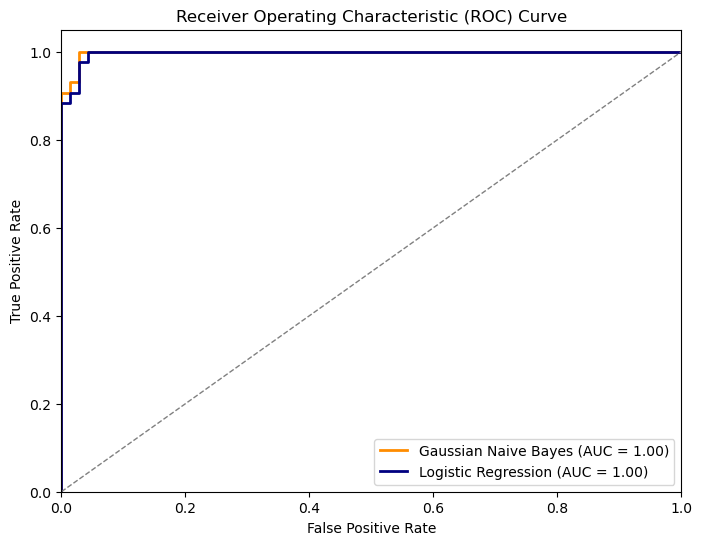

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Convert string labels to binary labels
y_true_binary = (y_test == 'M').astype(int)

# Calculate ROC curves for both models
fpr_nb, tpr_nb, _ = roc_curve(y_true_binary, nb_prob_predictions)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_lr, tpr_lr, _ = roc_curve(y_true_binary, lr_prob_predictions)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC curves for both models
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='Gaussian Naive Bayes (AUC = {:.2f})'.format(roc_auc_nb))
plt.plot(fpr_lr, tpr_lr, color='navy', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_lr))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



## Conclusion

- Best features for this dataset are: 'concavity_mean', 'concave points_mean', 'perimeter_worst',
       'area_worst', 'concave points_worst'.
- Naive Bayes works better and superior based on performance metrics. However Logistic Regression is slightly better on ROC AUC scores for **cross-validation**. 